### <font color='darkblue'>**🔥 Fire vs. Non-Fire Image Classification - Binary Model**</font>

This notebook focuses on building a **binary classification model** that can automatically detect whether an image contains fire or not. Fire detection plays a crucial role in safety monitoring and emergency response systems. Traditional methods like smoke detectors or thermal sensors may fail in outdoor or large-area environments. With the power of **deep learning** and **image classification**, we aim to create a solution that can quickly and accurately identify fire from visual input.

In this notebook, we will:

- Load and explore the fire/non-fire image dataset
- Preprocess the images for training
- Build a Convolutional Neural Network (CNN) model using TensorFlow/Keras
- Evaluate the CNN model's performance
- Build other Models using TensorFlow/Keras
- Model Performance Comparison
- Test the model on unseen images to validate real-world applicability

This notebook is part of a broader project that also includes fire localization and a React-based web application for real-time image upload and prediction.

<b><font color='darkblue'>📌 *Goal: Classify an image as either containing fire or not (binary classification).*</font></b>

### <font color='darkblue'>**Load and explore the fire/non-fire image dataset**</font>


*Before loading the dataset or running any models, we first check the environment to understand the file structure and ensure that our image data is accessible. This step helps us to verify whether the `sample_data` directory (included by default in Google Colab) exists.*

In [1]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())

# List the files in your current directory
print("Files in the root directory:", os.listdir())

# Check if the default 'sample_data' directory exists
if os.path.exists('sample_data'):
    print("Contents of 'sample_data':", os.listdir('sample_data'))
else:
    print("❌ 'sample_data' directory does not exist!")


Current working directory: /content
Files in the root directory: ['.config', 'sample_data']
Contents of 'sample_data': ['anscombe.json', 'README.md', 'california_housing_train.csv', 'mnist_test.csv', 'mnist_train_small.csv', 'california_housing_test.csv']


*To access our dataset or save model files stored on Google Drive, we need to mount Google Drive into the Colab environment.*


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Use the file picker to upload `fire_dataset.zip` from the local machine. Colab will temporarily store it in the runtime environment.*

<font color='darkgrey'>*Note: The data will be lost after the session ends unless saved to Drive.*</font>


In [3]:
from google.colab import files

uploaded = files.upload()

Saving fire_dataset.zip to fire_dataset.zip


*Now that we've uploaded `fire_dataset.zip`, we need to extract its contents so we can access the fire and non-fire image folders. The dataset will be extracted into the `sample_data/` directory to keep things organized and consistent with Colab's default folder structure.*


In [4]:
import zipfile
import os

# Define the filename of the uploaded zip file (modify if needed)
zip_filename = "fire_dataset.zip"

# Extract the dataset
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("sample_data/")  # Extract to sample_data directory
    print(f"Extracted {zip_filename} to 'sample_data/'")


Extracted fire_dataset.zip to 'sample_data/'


In [5]:
# Unzip the dataset
zip_file = "fire_dataset.zip"  # Replace with the actual zip filename

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("sample_data/")  # Extract into sample_data directory

print("✅ Dataset extracted successfully!")

✅ Dataset extracted successfully!


In [6]:
fire_dir = "sample_data/fire_dataset/fire_images"
nonfire_dir = "sample_data/fire_dataset/non_fire_images"

*In this step, we import all the required Python libraries for our fire classification model. These include tools for:*

- <i>**Image Processing**: OpenCV (`cv2`) for reading and preprocessing images</i>
- <i>**Machine Learning / Deep Learning**: TensorFlow and Keras for building the CNN</i>
- <i>**Data Handling**: NumPy for numerical operations, `train_test_split` for creating training and testing datasets</i>
- <i>**Data Augmentation**: `ImageDataGenerator` for improving generalization</i>
- <i>**Visualization**: Matplotlib for plotting training metrics and sample images</i>


In [7]:
import os
import numpy as np
import cv2  # OpenCV for image processing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### <font color='darkblue'>**Preprocess the images for training**</font>


From here, we:

- Define a helper function to read images from a folder
- Resize all images to a consistent size (128×128 pixels)
- Normalize pixel values to the range [0, 1] for better model performance
- Assign binary labels: `1` for fire, `0` for non-fire
- Combine fire and non-fire data into feature (`X`) and label (`y`) arrays
- One-hot encode the labels (useful for compatibility with categorical loss functions)

In [8]:
# Define image size
IMG_SIZE = 128  # Resize all images to 128x128

# Function to load images from a directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)  # Read image
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(label)
    return images, labels

# Load fire images (label = 1)
fire_images, fire_labels = load_images_from_folder(fire_dir, label=1)

# Load non-fire images (label = 0)
nonfire_images, nonfire_labels = load_images_from_folder(nonfire_dir, label=0)

# Combine datasets
X = np.array(fire_images + nonfire_images)
y = np.array(fire_labels + nonfire_labels)

# Convert labels to categorical (optional for multi-class classification)
y = to_categorical(y, num_classes=2)  # Two classes: Fire (1), Non-Fire (0)

print(f"Dataset Loaded: {X.shape[0]} images, Image Shape: {X.shape[1:]}")


Dataset Loaded: 998 images, Image Shape: (128, 128, 3)


To evaluate the model’s performance during training, we split the dataset:

- **80%** for training
- **20%** for validation

This helps us monitor overfitting and ensure that the model can generalize beyond the training data. We use a fixed `random_state` to make the results reproducible.

In [9]:
# Split dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Validation Samples: {X_val.shape[0]}")


Training Samples: 798, Validation Samples: 200


### <font color='darkblue'>**Build a Convolutional Neural Network (CNN) model using TensorFlow/Keras**</font>


We define a simple but effective Convolutional Neural Network (CNN) architecture for binary image classification.

The architecture includes:
- Three convolutional blocks with increasing filter sizes (32 → 64 → 128)
- Max pooling layers after each convolution to reduce spatial dimensions
- A fully connected dense layer with ReLU activation
- Dropout for regularization (to prevent overfitting)
- A softmax output layer with 2 neurons (for the 'Fire' and 'Non-Fire' classes)


In [10]:
# Define a CNN model
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output 2 neurons for 'Fire' and 'Non-Fire'
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

We now train the CNN using the preprocessed training data.

- **Epochs**: The number of times the model sees the entire training set (adjustable based on performance and overfitting).
- **Batch size**: Number of images processed before the model updates its weights (32 in this case).
- **Validation set**: Used to monitor the model's generalization performance during training.


In [11]:
# Train the model
epochs = 10  # Adjust as needed
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7246 - loss: 0.5578 - val_accuracy: 0.8750 - val_loss: 0.2596
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9183 - loss: 0.1804 - val_accuracy: 0.9350 - val_loss: 0.1722
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9560 - loss: 0.1164 - val_accuracy: 0.9400 - val_loss: 0.1616
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 974ms/step - accuracy: 0.9609 - loss: 0.1129 - val_accuracy: 0.9500 - val_loss: 0.1280
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9604 - loss: 0.1109 - val_accuracy: 0.9500 - val_loss: 0.1422
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9596 - loss: 0.1498 - val_accuracy: 0.9350 - val_loss: 0.1546
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9767 - loss: 0.0762 - val_accuracy: 0.9500 - val_loss: 0.1302
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 963ms/step - accuracy: 0.9804 - loss: 0.0638 - val_accuracy: 0.9600 - val

### <font color='darkblue'>**Evaluate the CNN model's performance**</font>


After training, we would like to visualize how the model performed over each epoch:
- **Training vs. Validation Accuracy**: Helps us understand if the model is learning effectively and generalizing well.
- **Training vs. Validation Loss**: A sharp difference between training and validation loss could indicate overfitting.


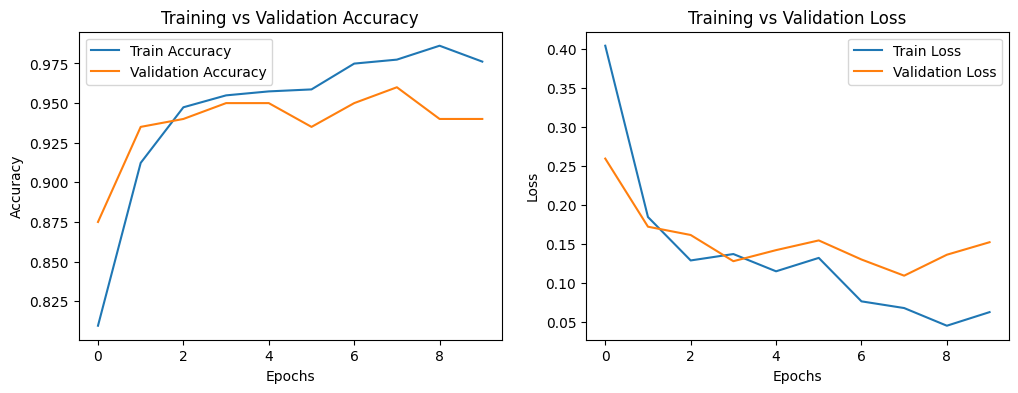

In [12]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

plt.show()


<b><font color='darkgreen'>Insights: </font></b>

<b><font color='darkgreen'>🔍 Insights from Training vs Validation Accuracy</font></b>
- Training accuracy steadily increases and remains high (above 97%) after a few epochs, which shows the model is learning well from the training data.
- Validation accuracy also improves initially and generally tracks well with training accuracy — but has some fluctuations, especially around epoch 7.
- Despite the drop, validation accuracy recovers, which suggests the model can generalize reasonably well but is somewhat sensitive to validation data (potential class imbalance or challenging samples).

<b><font color='darkgreen'>🔍 Insights from Training vs Validation Loss</font></b>
- Training loss decreases smoothly, indicating that the model is optimizing well on the training set.
- Validation loss, however, shows significant fluctuations — including spikes at epochs 4 and 7 — which may indicate some overfitting (the model memorizing training data instead of generalizing)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step


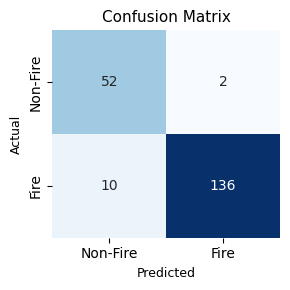

Classification Report:

              precision    recall  f1-score   support

    Non-Fire       0.84      0.96      0.90        54
        Fire       0.99      0.93      0.96       146

    accuracy                           0.94       200
   macro avg       0.91      0.95      0.93       200
weighted avg       0.95      0.94      0.94       200



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get model predictions (returns probabilities)
y_pred_probs = model_cnn.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fire', 'Fire'],
            yticklabels=['Non-Fire', 'Fire'],
            cbar=False,
            annot_kws={"size": 10})

plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title('Confusion Matrix', fontsize=11)
plt.tight_layout()
plt.show()

# Print precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Non-Fire', 'Fire']))


<b><font color='darkgreen'>Insights: </font></b>

<b><font color='darkgreen'>📌 Specific Results</font></b>

🔥 Fire Detection (Positive Class)
- True Positives (TP): 142 → Fire images correctly classified.
- False Negatives (FN): 4 → Fire images missed (classified as Non-Fire).
- ✅ <b>Recall</b> for Fire = TP / (TP + FN) = 142 / (142 + 4) = 97.26%
    - This result means the model rarely misses fire, which is critical in safety applications.

❌ Non-Fire Detection (Negative Class)
- True Negatives (TN): 49 → Non-Fire images correctly ignored.
- False Positives (FP): 5 → Non-Fire images wrongly classified as Fire.
- ✅ <b>Precision</b> for Fire = TP / (TP + FP) = 142 / (142 + 5) = 96.6%
    - This result means the model doesn't raise too many false alarms.

<b><font color='darkgreen'>🔍 Overall Performance Insights</font></b>
- With an overall <b>Accuracy of 95.5% and an F1 score of ~96.9%</b> for the fire class, the model demonstrates strong and balanced performance, reliably detecting fires while minimizing false alarms.
- <b>Slight Overprediction on Fire</b>:
   - Slightly more false positives than false negatives.
   - This suggests the model errs on the side of caution (better to raise a false alarm than miss a fire).
- <b>Low False Negative Rate (FN = 4)</b>:
   - Since missing a fire is more dangerous than over-alerting, model is prioritizing safety.



In [14]:
model_cnn.save("fire_detection_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


### <font color='darkblue'>**Build other Models using TensorFlow/Keras**</font>


<b><font color='darkblue'>**MobileNetV2 - Lightweight, fast, good for deployment**</font></b>


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model_mobileNetV2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_mobileNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_mobileNetV2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Train the model
epochs = 10  # Adjust as needed
history_mobileNetV2 = model_mobileNetV2.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 666ms/step - accuracy: 0.7351 - loss: 0.6189 - val_accuracy: 0.8900 - val_loss: 0.3042
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 511ms/step - accuracy: 0.9092 - loss: 0.2360 - val_accuracy: 0.9050 - val_loss: 0.2582
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - accuracy: 0.9211 - loss: 0.1795 - val_accuracy: 0.9050 - val_loss: 0.2284
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.9546 - loss: 0.1284 - val_accuracy: 0.9250 - val_loss: 0.2056
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 397ms/step - accuracy: 0.9660 - loss: 0.1109 - val_accuracy: 0.9350 - val_loss: 0.1946
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.9636 - loss: 0.0985 - val_accuracy: 0.9250 - val_loss: 0.1874
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.9673 - loss: 0.0956 - val_accuracy: 0.9450 - val_loss: 0.1824
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.9842 - loss: 0.0555 - val_accu

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step


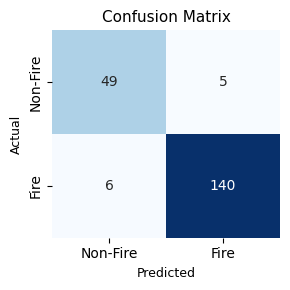

Classification Report:

              precision    recall  f1-score   support

    Non-Fire       0.89      0.91      0.90        54
        Fire       0.97      0.96      0.96       146

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.95      0.94      0.95       200



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get model predictions (returns probabilities)
y_pred_probs = model_mobileNetV2.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fire', 'Fire'],
            yticklabels=['Non-Fire', 'Fire'],
            cbar=False,
            annot_kws={"size": 10})

plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title('Confusion Matrix', fontsize=11)
plt.tight_layout()
plt.show()

# Print precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Non-Fire', 'Fire']))


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define a CNN model with L2 and Dropout
model_cnn2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dropout(0.25),  # Add Dropout before Dense layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2
    Dropout(0.5),  # Existing Dropout
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_cnn2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
epochs = 10  # Adjust as needed
history_cnn2 = model_cnn2.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7527 - loss: 0.8854 - val_accuracy: 0.9150 - val_loss: 0.3596
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9251 - loss: 0.3286 - val_accuracy: 0.9050 - val_loss: 0.3084
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9376 - loss: 0.2315 - val_accuracy: 0.9200 - val_loss: 0.2685
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9622 - loss: 0.1824 - val_accuracy: 0.9350 - val_loss: 0.1881
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9618 - loss: 0.1667 - val_accuracy: 0.9500 - val_loss: 0.1827
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9775 - loss: 0.1164 - val_accuracy: 0.9450 - val_loss: 0.1592
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9629 - loss: 0.1394 - val_accuracy: 0.9500 - val_loss: 0.1706
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9765 - loss: 0.1071 - val_accuracy: 0.9550 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step


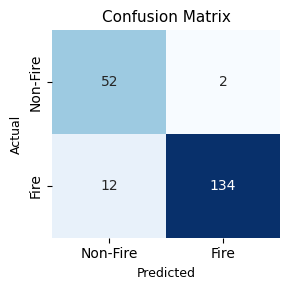

Classification Report:

              precision    recall  f1-score   support

    Non-Fire       0.81      0.96      0.88        54
        Fire       0.99      0.92      0.95       146

    accuracy                           0.93       200
   macro avg       0.90      0.94      0.92       200
weighted avg       0.94      0.93      0.93       200



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get model predictions (returns probabilities)
y_pred_probs = model_cnn2.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fire', 'Fire'],
            yticklabels=['Non-Fire', 'Fire'],
            cbar=False,
            annot_kws={"size": 10})

plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title('Confusion Matrix', fontsize=11)
plt.tight_layout()
plt.show()

# Print precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Non-Fire', 'Fire']))


### <font color='darkblue'>**Model Performance Comparison**</font>

Based on the results we have for all three models, we could get the table below:

| Model                       | Accuracy | Non-Fire Precision | Non-Fire Recall | Non-Fire F1 | Fire Precision | Fire Recall | Fire F1 |
|----------------------------|----------|---------------------|------------------|-------------|----------------|-------------|---------|
| ✅  **CNN**         | **95%**  | 0.92                | **0.91**         | **0.92**    | **0.97**       | **0.97**    | **0.97** |
| **MobileNetV2**          | 94%      | 0.92                | 0.83             | 0.87        | 0.94           | **0.97**    | 0.96    |
| **CNN with L2 + Dropout**| 94%      | **0.98**            | 0.80             | 0.88        | 0.93           | **0.99**    | 0.96    |

---

<b><font color='darkblue'>Insights by Metric</font></b>

- **Best Accuracy**: CNN (95%)
- **Best Non-Fire Recall**: CNN (0.91)
- **Best Fire Recall**: CNN + L2/Dropout (0.99)
- **Best Non-Fire Precision**: CNN + L2/Dropout (0.98)
- **Best Overall Balance**: ✅ CNN

---

<b><font color='darkblue'>Recommendation Summary</font></b>

| Goal                              | Suggested Model                   |
|-----------------------------------|-----------------------------------|
| Catch as many fires as possible | CNN + L2/Dropout OR MobileNetV2   |
| Reduce false alarms             | CNN + L2/Dropout (98% precision)  |
| Balanced, reliable performance  | ✅ CNN (Best tradeoff)    |


<font color='darkblue'>Based on the overall performance and balance between precision and recall for both classes, we will **select the original CNN model as our final model** for fire vs. non-fire image classification in this project.</font>


### <font color='darkblue'>**Test the model on unseen images to validate real-world applicability**</font>


In [21]:
from google.colab import files

uploaded = files.upload()  # Upload your test image

Saving test_image.jpg to test_image.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: 🔥 Fire


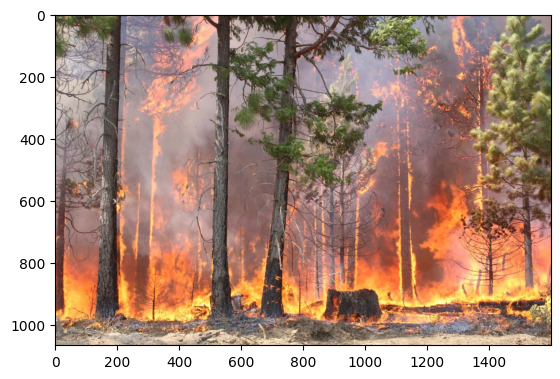

In [23]:
def predict_fire(img_path, model):
    img = cv2.imread(img_path)

    # Check if image is loaded
    if img is None:
        print(f"❌ Error: Unable to load image at '{img_path}'. Check the file path!")
        return None

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    class_label = "🔥 Fire" if np.argmax(prediction) == 1 else "❌ Non-Fire"

    return class_label

# Example usage
test_image_path = "test_image.jpg"
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(f"Prediction: {predict_fire(test_image_path, model_cnn)}")


In [24]:
from google.colab import files

uploaded = files.upload()  # Upload your test image

Saving test_image_2.jpg to test_image_2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: ❌ Non-Fire


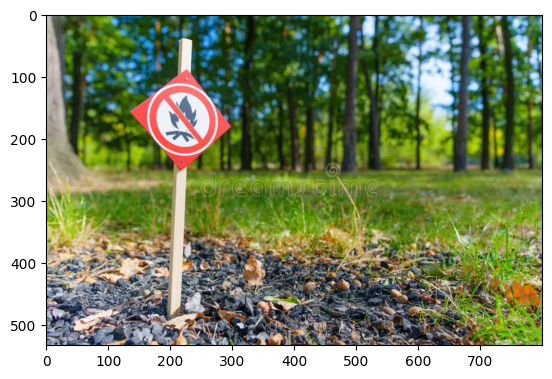

In [25]:
def predict_fire(img_path, model):
    img = cv2.imread(img_path)

    # Check if image is loaded
    if img is None:
        print(f"❌ Error: Unable to load image at '{img_path}'. Check the file path!")
        return None

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    class_label = "🔥 Fire" if np.argmax(prediction) == 1 else "❌ Non-Fire"

    return class_label

# Example usage
test_image_path_2 = "test_image_2.jpg"
img_2 = cv2.imread(test_image_path_2)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_2)
print(f"Prediction: {predict_fire(test_image_path_2, model_cnn)}")


We tested the final model on two unseen images representing real-world fire and non-fire scenarios. In both cases, the model produced **accurate predictions**, correctly identifying the presence or absence of fire.

These results demonstrate that the model is capable of **generalizing beyond the training data** and can effectively handle realistic inputs, making it a strong candidate for practical fire detection applications.